# Introduction
The goal of this competition is to detect blindness before it happens, organized by APTOS, data taken from Aravind Eye Hospitals here in my home country India.
This kernel is meant to provide a good starting point for those who use PyTorch for training and fine-tuning your models.


### Motivation: (From Competition Description)

Millions of people suffer from diabetic retinopathy, the leading cause of blindness among working aged adults. Aravind Eye Hospital in India hopes to detect and prevent this disease among people living in rural areas where medical screening is difficult to conduct. Successful entries in this competition will improve the hospital’s ability to identify potential patients.


### Evaluation Metric:
**Quadratic Kappa Score**  is a very useful, but under-utilised, metric. Sometimes in machine learning we are faced with a multi-class classification problem. In those cases, measures such as the accuracy, or precision/recall do not provide the complete picture of the performance of our classifier.

Cohen’s kappa statistic is a very good measure that can handle very well both multi-class and imbalanced class problems. 

Cohen’s kappa is always less than or equal to 1. Values of 0 or less, indicate that the classifier is useless. There is no standardized way to interpret its values. Landis and Koch (1977) provide a way to characterize values. According to their scheme a value < 0 is indicating no agreement , 0–0.20 as slight, 0.21–0.40 as fair, 0.41–0.60 as moderate, 0.61–0.80 as substantial, and 0.81–1 as almost perfect agreement.

References: 
[Cohen's Kappa Statistic](https://thedatascientist.com/performance-measures-cohens-kappa-statistic/), [Wiki](https://en.wikipedia.org/wiki/Cohen%27s_kappa)

#### Please UPVOTE this kernel if you find this useful.

# Import the essentials

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # Plotting
import seaborn as sns # Plotting

# Import Image Libraries - Pillow and OpenCV
from PIL import Image
import cv2

# Import PyTorch and useful fuctions
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import torch.optim as optim
import torchvision.models as models # Pre-Trained models

# Import useful sklearn functions
import sklearn
from sklearn.metrics import cohen_kappa_score, accuracy_score

import time
from tqdm import tqdm_notebook

import os
print(os.listdir("./input"))
base_dir = "./input"

['sample_submission.csv', 'train.csv', 'test_images', 'pretrained-models', 'test.csv', 'train_images']


# Loading Data + EDA

In [2]:
train_csv = pd.read_csv('./input/train.csv')
test_csv = pd.read_csv('./input/test.csv')

In [3]:
print('Train Size = {}'.format(len(train_csv)))
print('Public Test Size = {}'.format(len(test_csv)))

Train Size = 3662
Public Test Size = 1928


In [4]:
train_csv.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


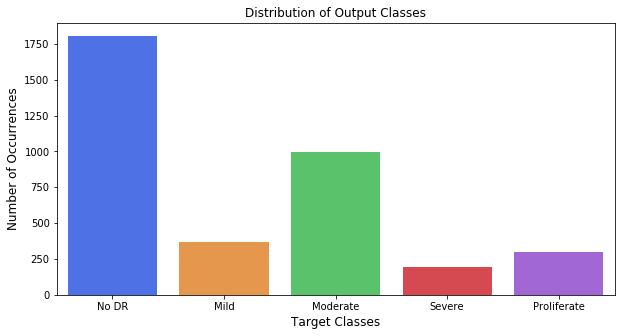

In [5]:
counts = train_csv['diagnosis'].value_counts()
class_list = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferate']
for i,x in enumerate(class_list):
    counts[x] = counts.pop(i)

plt.figure(figsize=(10,5))
sns.barplot(counts.index, counts.values, alpha=0.8, palette='bright')
plt.title('Distribution of Output Classes')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Target Classes', fontsize=12)
plt.show()

# Visualizing Training Data

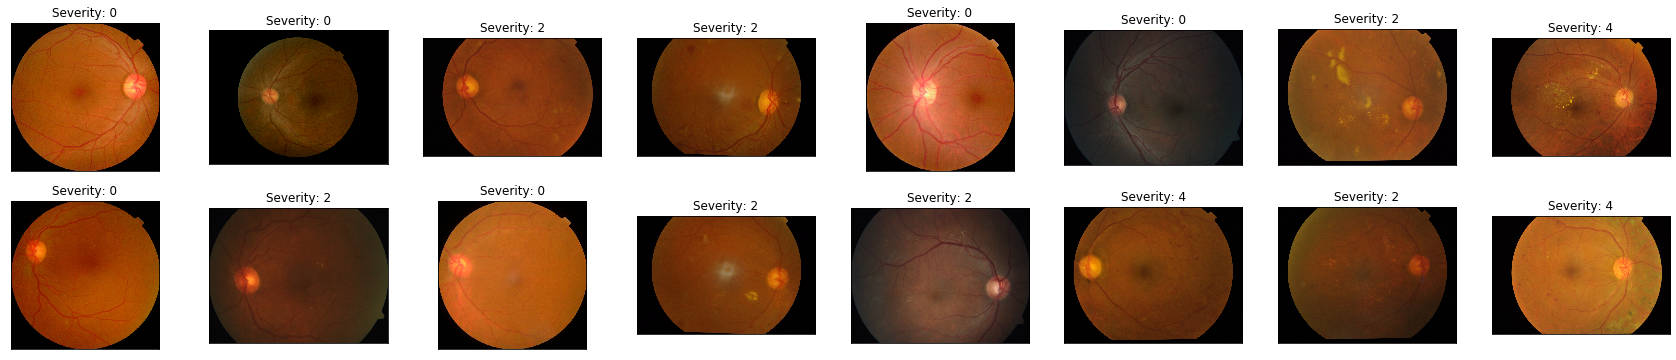

In [6]:
fig = plt.figure(figsize=(30, 6))
# display 20 images
train_imgs = os.listdir(base_dir+"/train_images")
for idx, img in enumerate(np.random.choice(train_imgs, 16)):
    ax = fig.add_subplot(2, 16//2, idx+1, xticks=[], yticks=[])
    im = Image.open(base_dir+"/train_images/" + img)
    plt.imshow(im)
    lab = train_csv.loc[train_csv['id_code'] == img.split('.')[0], 'diagnosis'].values[0]
    ax.set_title('Severity: %s'%lab)

# Visualizing Test Set

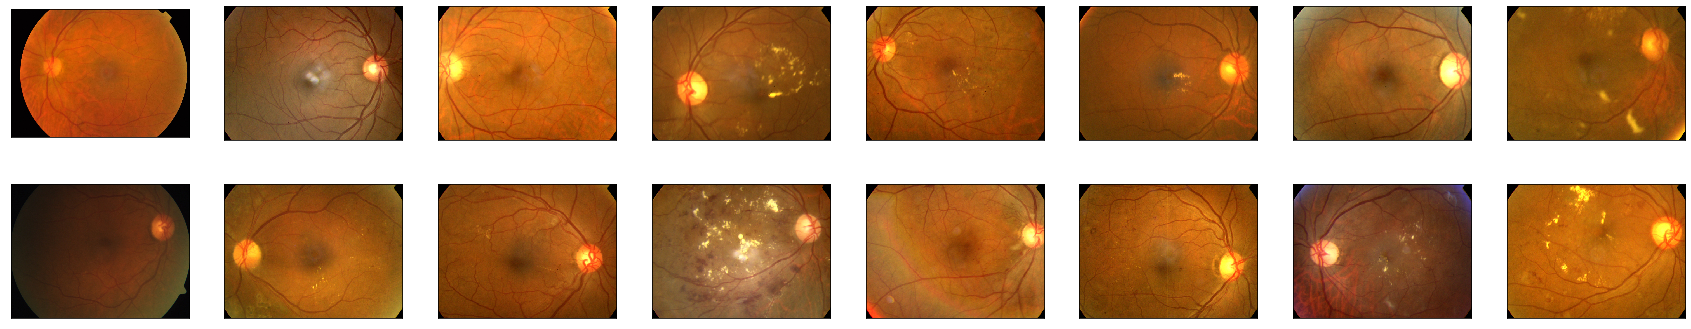

In [7]:
fig = plt.figure(figsize=(30, 6))
# display 20 images
test_imgs = os.listdir(base_dir+"/test_images")
for idx, img in enumerate(np.random.choice(test_imgs, 16)):
    ax = fig.add_subplot(2, 16//2, idx+1, xticks=[], yticks=[])
    im = Image.open(base_dir+"/test_images/" + img)
    plt.imshow(im)

# Data Processing

In [8]:
# Our own custom class for datasets
class CreateDataset(Dataset):
    def __init__(self, df_data, data_dir = './input/', transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name+'.png')
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [9]:
transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.4),
    #transforms.ColorJitter(brightness=2, contrast=2),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [10]:
train_path = "./input/train_images/"
test_path = "./input/test_images/"

In [11]:
 train_data = CreateDataset(df_data=train_csv, data_dir=train_path, transform=transforms)

In [12]:
# Set Batch Size
batch_size = 32

# Percentage of training set to use as validation
valid_size = 0.2

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Create Samplers
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)

# Define Model Architecture

In [13]:
model = models.resnet101(pretrained=False)
model.load_state_dict(torch.load("./input/pretrained-models/resnet101-5d3b4d8f.pth"))
# for param in model.parameters():
#     param.requires_grad = False
model.avg_pool = nn.AdaptiveAvgPool2d(output_size=(1,1))
model.fc = nn.Sequential(
                  nn.Linear(in_features=2048, out_features=1024, bias=True),
                  nn.Dropout(0.25),
                  nn.Linear(in_features=1024, out_features=512, bias=True),
                  nn.Dropout(0.1),
                  nn.Linear(in_features=512, out_features=1, bias=True)
            )



In [14]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    model.cuda()

CUDA is available!  Training on GPU ...


In [15]:
# Trainable Parameters
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

Number of trainable parameters: 
45123649


# Training (Fine Tuning) and Validation

In [16]:
# specify loss function (categorical cross-entropy loss)
criterion = nn.MSELoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0015)

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
# number of epochs to train the model
n_epochs = 35

valid_loss_min = np.Inf

# keeping track of losses as it happen
train_losses = []
valid_losses = []
val_kappa = []
test_accuracies = []
valid_accuracies = []
kappa_epoch = []
batch = 0

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in tqdm_notebook(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cpu().float()
        target = target.view(-1, 1)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data).cpu()
            # calculate the batch loss
            loss = criterion(output, target).cpu()
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            data = data.cpu()
        # Update Train loss and accuracies
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in tqdm_notebook(valid_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda().float()
        # forward pass: compute predicted outputs by passing inputs to the model
        target = target.view(-1, 1)
        with torch.set_grad_enabled(True):
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        #output = output.cohen_kappa_score_kappa_score)
        y_actual = target.data.cpu().numpy()
        y_pred = output[:,-1].detach().cpu().numpy()
        val_kappa.append(cohen_kappa_score(y_actual, y_pred.round()))        
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    valid_kappa = np.mean(val_kappa)
    kappa_epoch.append(np.mean(val_kappa))
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print training/validation statistics 
    print('Epoch: {} | Training Loss: {:.6f} | Val. Loss: {:.6f} | Val. Kappa Score: {:.4f}'.format(
        epoch, train_loss, valid_loss, valid_kappa))
    
    ##################
    # Early Stopping #
    ##################
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'best_model.pt')
        valid_loss_min = valid_loss


Epoch: 1 | Training Loss: 7.839048 | Val. Loss: 1.852535 | Val. Kappa Score: 0.0195
Validation loss decreased (inf --> 1.852535).  Saving model ...



Epoch: 2 | Training Loss: 1.786864 | Val. Loss: 1.638675 | Val. Kappa Score: 0.0120
Validation loss decreased (1.852535 --> 1.638675).  Saving model ...



Epoch: 3 | Training Loss: 1.229577 | Val. Loss: 2.403767 | Val. Kappa Score: 0.0377



Epoch: 4 | Training Loss: 0.825406 | Val. Loss: 1.035354 | Val. Kappa Score: 0.0512
Validation loss decreased (1.638675 --> 1.035354).  Saving model ...



Epoch: 5 | Training Loss: 0.664242 | Val. Loss: 1.108987 | Val. Kappa Score: 0.0866



Epoch: 6 | Training Loss: 0.537947 | Val. Loss: 0.546532 | Val. Kappa Score: 0.1419
Validation loss decreased (1.035354 --> 0.546532).  Saving model ...



Epoch: 7 | Training Loss: 0.450638 | Val. Loss: 0.480725 | Val. Kappa Score: 0.2010
Validation loss decreased (0.546532 --> 0.480725).  Saving model ...



Epoch: 8 | Training Loss: 0.403457 | Val. Loss: 0.405180 | Val. Kappa Score: 0.2459
Validation loss decreased (0.480725 --> 0.405180).  Saving model ...



Epoch: 9 | Training Loss: 0.388494 | Val. Loss: 0.399892 | Val. Kappa Score: 0.2822
Validation loss decreased (0.405180 --> 0.399892).  Saving model ...



Epoch: 10 | Training Loss: 0.353249 | Val. Loss: 0.378808 | Val. Kappa Score: 0.3125
Validation loss decreased (0.399892 --> 0.378808).  Saving model ...



Epoch: 11 | Training Loss: 0.330100 | Val. Loss: 0.526253 | Val. Kappa Score: 0.3256



Epoch: 12 | Training Loss: 0.332740 | Val. Loss: 0.341901 | Val. Kappa Score: 0.3471
Validation loss decreased (0.378808 --> 0.341901).  Saving model ...



Epoch: 13 | Training Loss: 0.304280 | Val. Loss: 0.337003 | Val. Kappa Score: 0.3652
Validation loss decreased (0.341901 --> 0.337003).  Saving model ...



Epoch: 14 | Training Loss: 0.273662 | Val. Loss: 0.329236 | Val. Kappa Score: 0.3831
Validation loss decreased (0.337003 --> 0.329236).  Saving model ...



Epoch: 15 | Training Loss: 0.267071 | Val. Loss: 0.397892 | Val. Kappa Score: 0.3968



Epoch: 16 | Training Loss: 0.301306 | Val. Loss: 0.396352 | Val. Kappa Score: 0.4080



Epoch: 17 | Training Loss: 0.280003 | Val. Loss: 0.386719 | Val. Kappa Score: 0.4194



Epoch: 18 | Training Loss: 0.262890 | Val. Loss: 0.442990 | Val. Kappa Score: 0.4262



Epoch: 19 | Training Loss: 0.219070 | Val. Loss: 0.340682 | Val. Kappa Score: 0.4366



Epoch: 20 | Training Loss: 0.224895 | Val. Loss: 0.341210 | Val. Kappa Score: 0.4450



Epoch: 21 | Training Loss: 0.219949 | Val. Loss: 0.447247 | Val. Kappa Score: 0.4521



Epoch: 22 | Training Loss: 0.233109 | Val. Loss: 0.403762 | Val. Kappa Score: 0.4589



Epoch: 23 | Training Loss: 0.244597 | Val. Loss: 1.490444 | Val. Kappa Score: 0.4492



Epoch: 24 | Training Loss: 0.205595 | Val. Loss: 0.454356 | Val. Kappa Score: 0.4520



Epoch: 25 | Training Loss: 0.216783 | Val. Loss: 0.320865 | Val. Kappa Score: 0.4576
Validation loss decreased (0.329236 --> 0.320865).  Saving model ...



Epoch: 26 | Training Loss: 0.197825 | Val. Loss: 0.300037 | Val. Kappa Score: 0.4656
Validation loss decreased (0.320865 --> 0.300037).  Saving model ...



Epoch: 27 | Training Loss: 0.157266 | Val. Loss: 0.406805 | Val. Kappa Score: 0.4709



Epoch: 28 | Training Loss: 0.158760 | Val. Loss: 0.381548 | Val. Kappa Score: 0.4738



Epoch: 29 | Training Loss: 0.153973 | Val. Loss: 0.370289 | Val. Kappa Score: 0.4768



Epoch: 30 | Training Loss: 0.265455 | Val. Loss: 0.566071 | Val. Kappa Score: 0.4720



Epoch: 31 | Training Loss: 0.253430 | Val. Loss: 0.354710 | Val. Kappa Score: 0.4766



Epoch: 32 | Training Loss: 0.199234 | Val. Loss: 0.355571 | Val. Kappa Score: 0.4785



Epoch: 33 | Training Loss: 0.159593 | Val. Loss: 0.350154 | Val. Kappa Score: 0.4823



Epoch: 34 | Training Loss: 0.163694 | Val. Loss: 0.320656 | Val. Kappa Score: 0.4862



Epoch: 35 | Training Loss: 0.159733 | Val. Loss: 0.341793 | Val. Kappa Score: 0.4892


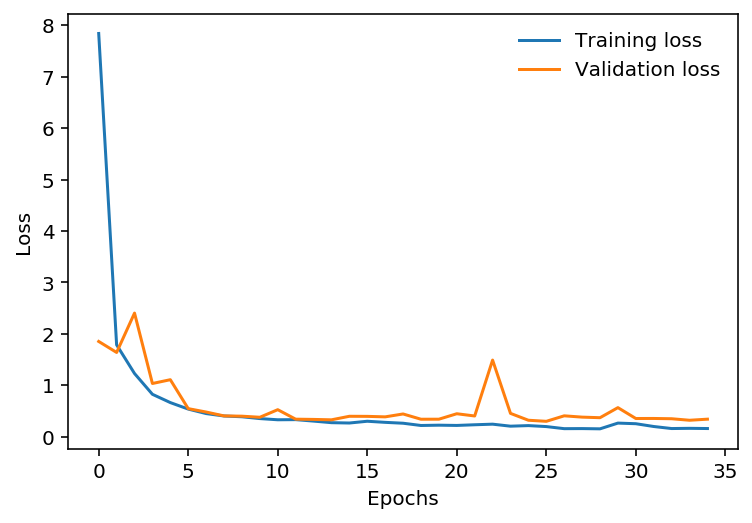

In [19]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

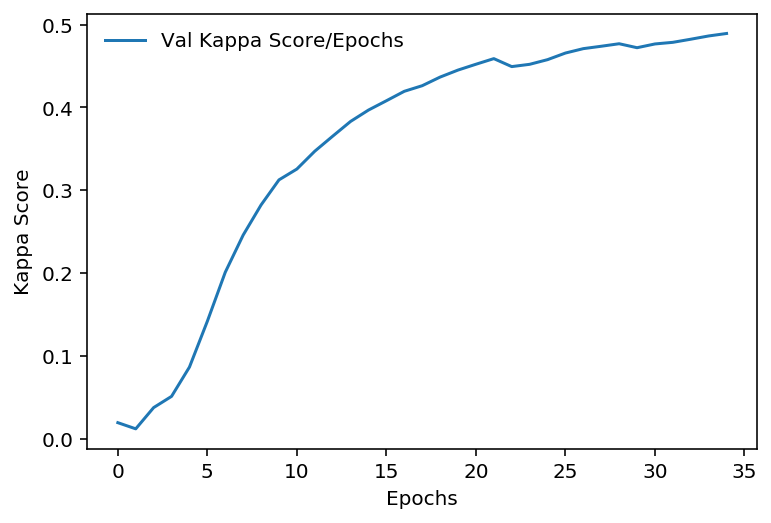

In [20]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(kappa_epoch, label='Val Kappa Score/Epochs')
plt.legend("")
plt.xlabel("Epochs")
plt.ylabel("Kappa Score")
plt.legend(frameon=False)

In [21]:
model.load_state_dict(torch.load('best_model.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

# Inference

In [22]:
test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((224, 224)),
    #torchvision.transforms.ColorJitter(brightness=2, contrast=2),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [23]:
test_csv['diagnosis'] = -1

In [24]:
test_data = CreateDataset(df_data=test_csv, data_dir=test_path, transform=test_transforms)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [25]:
 def round_off_preds(preds, coef=[0.5, 1.5, 2.5, 3.5]):
    for i, pred in enumerate(preds):
            if pred < coef[0]:
                preds[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                preds[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                preds[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                preds[i] = 3
            else:
                preds[i] = 4
    return preds

In [26]:
def predict(testloader):
    '''Function used to make predictions on the test set'''
    model.eval()
    preds = []
    for batch_i, (data, target) in enumerate(testloader):
        data, target = data.cuda(), target.cuda()
        output = model(data)
        pr = output.detach().cpu().numpy()
        for i in pr:
            preds.append(i.item())
            
    return preds

### TTA (Test Time Augmentation)

In [27]:
preds1 = np.array(predict(testloader=test_loader))

RuntimeError: CUDA out of memory. Tried to allocate 26.00 MiB (GPU 0; 10.75 GiB total capacity; 8.96 GiB already allocated; 26.81 MiB free; 434.18 MiB cached)

In [ ]:
preds2 = np.array(predict(testloader=test_loader))

In [ ]:
preds3 = np.array(predict(testloader=test_loader))

In [ ]:
preds4 = np.array(predict(testloader=test_loader))

In [ ]:
preds5 = np.array(predict(testloader=test_loader))

In [ ]:
preds6 = np.array(predict(testloader=test_loader))

In [ ]:
preds7 = np.array(predict(testloader=test_loader))

In [ ]:
preds8 = np.array(predict(testloader=test_loader))

In [ ]:
preds = (preds1 + preds2 + preds3 + preds4 + 
         preds5 + preds6 + preds7 + preds8)/8.0

In [ ]:
preds = round_off_preds(preds)

# Generating Submission File

In [ ]:
sample_sub = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')

In [ ]:
sample_sub.diagnosis = preds
sample_sub.diagnosis = sample_sub['diagnosis'].astype(int)

In [ ]:
sample_sub.head()

In [ ]:
sample_sub.to_csv('submission.csv', index=False)

In [46]:
from logger import Logger

df_logger = Logger('LOGS.csv', 'df')

In [51]:
print(df_logger.logsFile.loc[3]['cfg'])

from model import MainModel
from torch import optim
import torch.nn as nn
import os
from logger import Logger
from libs.earlystopping import EarlyStopping

class Config:
    def __init__(self):
        ## INFO ABOUT EXPERIMENT
        self.logsFileName = 'LOGS'
        self.seed = 13
        if os.path.exists('./Logs/' + self.logsFileName + '.csv'):
            self.df_logger = Logger(self.logsFileName, 'df')
            self.experiment_name = 'exp{}'.format(len(self.df_logger.logsFile)) + '_end_epoch'
        else:
            self.experiment_name = 'exp{}'.format(0) + '_end_epoch'



        ## MODEL PARAMETERS
        self.model_type = 'ResNet'

        self.model = MainModel(model_type=self.model_type).model
        self.pytorch_total_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)

        self.lr = 0.0015
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.scheduler = None
        self.criterion = nn.MSELoss()
        

#### Give this kernel an upvote if you found this helpful.

**Credits:** Abhishek's [Inference Kernel](https://www.kaggle.com/abhishek/pytorch-inference-kernel-lazy-tta)